# レスラー方程式(ランダムなシフト付きsin外力のある状態)

レスラー方程式の外力のある場合に関して，$sin$波に位相のランダムなシフトがある場合を考える．

In [26]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 1.91 µs


In [27]:
shifts = {}  # 4日ごとの位相シフトを格納する辞書

def phase_shift(t):
    # 4日ごとの区間を識別
    period = int(t / (4*2*np.pi))

    # 新しい位相シフトが必要かどうかをチェック
    if period not in shifts:
        random_shift_hour = np.random.choice(np.arange(-12, 12, 1)) #シフト範囲は -12 から +12
        shift_value = (random_shift_hour / 24) * 2 * np.pi
        shifts[period] = shift_value

    # 現在の位相シフトを返す
    return shifts[period]


def rossler_system_with_shifted_force(t, state, a, b, c, A):
    x, y, z = state
    dxdt = -y - z + A * np.sin(t + phase_shift(t))  # X項に外力P(t)を加える（位相シフト付き）
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]


In [28]:
# 外力P(t)の振幅Aをパラメータとして追加します。
A = 2.0  # 外力の振幅を設定します。この値を変更することで、外力の強さを変えられます。

# パラメータ
a = 0.2
b = 0.2
c = 5.7

# 初期条件
initial_state = [1.0, 1.0, 1.0]

# 時間の設定
t_span = [0, 4510]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 45100)  # 評価する時間点


In [29]:
# 微分方程式の数値解を求める
solution_with_shifted_force = solve_ivp(
    rossler_system_with_shifted_force, t_span, initial_state,
    args=(a, b, c, A), t_eval=t_eval, max_step=0.01
)

# 外力P(t)の計算（位相シフト付き）
P_shifted = A * np.sin(solution_with_shifted_force.t + np.array([phase_shift(ti) for ti in solution_with_shifted_force.t]))

# DataFrameの作成
data_frame_with_shifted_force = pd.DataFrame({
    'time': solution_with_shifted_force.t,
    'x': solution_with_shifted_force.y[0],
    'y': solution_with_shifted_force.y[1],
    'z': solution_with_shifted_force.y[2],
    'P_shifted': P_shifted  # 位相シフトされた外力P(t)の列を追加
})


In [30]:
dir_name = f"data"
os.makedirs(dir_name, exist_ok=True)

filename_with_force = f"{dir_name}/rossler_data_with_random_shifted_force.csv"

# CSVファイルにデータを保存
data_frame_with_shifted_force.to_csv(filename_with_force, index=False)

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values


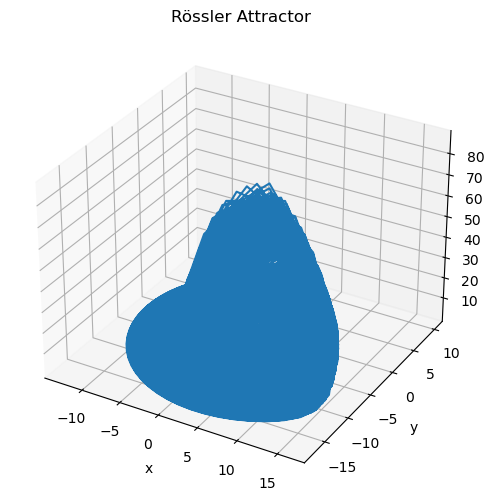

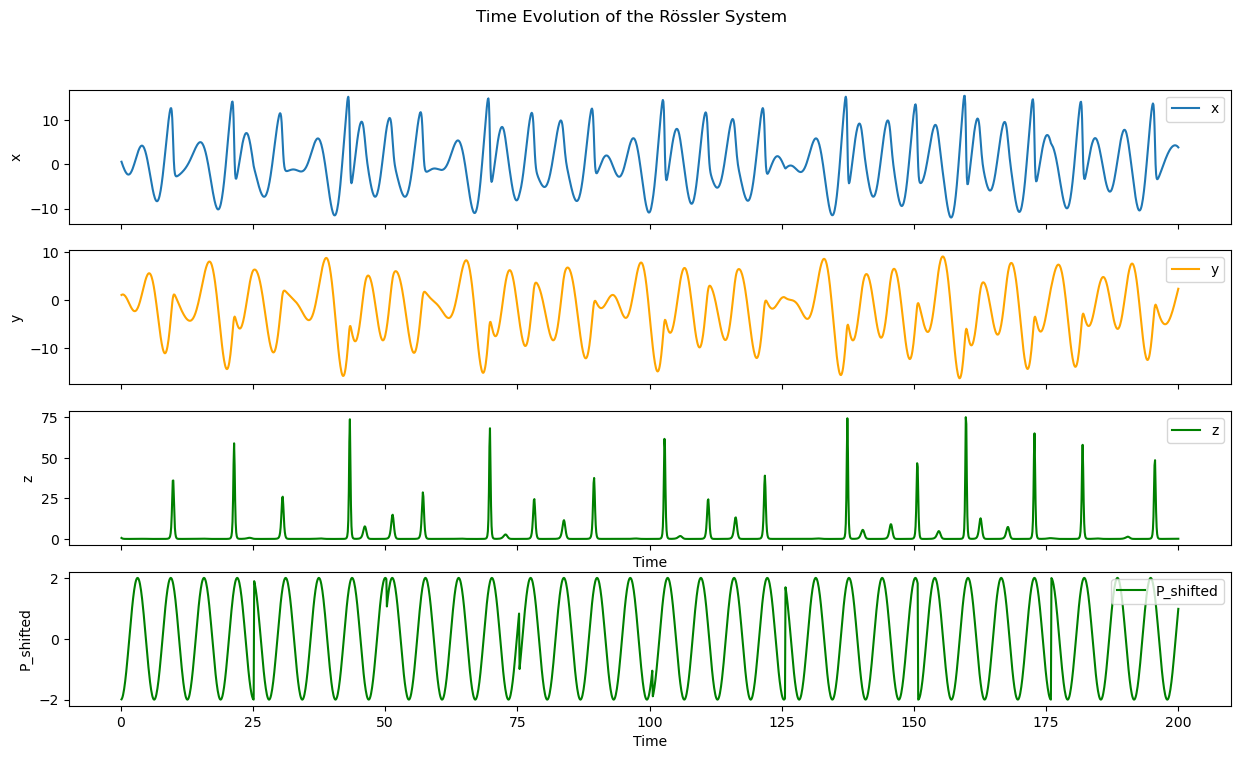

In [31]:
# XYZの三次元グラフをプロット
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_loaded_with_force['x'], data_loaded_with_force['y'], data_loaded_with_force['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rössler Attractor')
plt.show()

sample = 1
plot_length = 2000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['x'][sample: sample+plot_length], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['y'][sample: sample+plot_length], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

axs[2].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['z'][sample: sample+plot_length], label='z', color='green')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Time')
axs[2].legend(loc='upper right')

axs[3].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['P_shifted'][sample: sample+plot_length], label='P_shifted', color='green')
axs[3].set_ylabel('P_shifted')
axs[3].set_xlabel('Time')
axs[3].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()


In [32]:
print(shifts)


{0: -1.5707963267948966, 1: 1.8325957145940461, 2: 0.5235987755982988, 3: -0.5235987755982988, 4: -1.3089969389957472, 5: 2.0943951023931953, 6: -1.5707963267948966, 7: 1.5707963267948966, 8: 2.6179938779914944, 9: -0.5235987755982988, 10: -0.5235987755982988, 11: 2.8797932657906435, 12: 2.0943951023931953, 13: -2.356194490192345, 14: -1.3089969389957472, 15: 2.8797932657906435, 16: -2.6179938779914944, 17: 2.356194490192345, 18: 2.0943951023931953, 19: -2.8797932657906435, 20: 2.8797932657906435, 21: -0.2617993877991494, 22: -1.8325957145940461, 23: -2.8797932657906435, 24: 2.0943951023931953, 25: -3.141592653589793, 26: -0.2617993877991494, 27: 2.356194490192345, 28: -0.2617993877991494, 29: 1.0471975511965976, 30: -0.7853981633974483, 31: 0.7853981633974483, 32: 0.5235987755982988, 33: 0.5235987755982988, 34: 1.5707963267948966, 35: -0.2617993877991494, 36: 2.6179938779914944, 37: 1.8325957145940461, 38: -2.6179938779914944, 39: -2.0943951023931953, 40: 1.5707963267948966, 41: -1.57